In [3]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD


## Load Dataset
### TMDB 5000 Movie Dataset
https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata

In [4]:
movies_df=pd.read_csv("tmdb_5000_movies.csv")
movies_df = movies_df.dropna()
movies_df.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [5]:
credit_df=pd.read_csv("tmdb_5000_credits.csv")
credit_df = credit_df.dropna()
credit_df.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


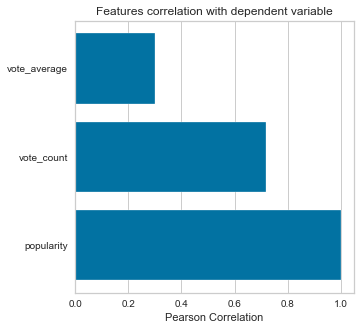

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [6]:
from yellowbrick.target import FeatureCorrelation

feature_names = [ 'popularity', 'vote_count','vote_average']

X, y = movies_df[feature_names], movies_df['popularity']

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(5,5)
visualizer.fit(X, y)     # Fit the data to the visualizer
visualizer.show()

## Analysis of the Dataset
- When we think of recommending to users the best movies, we should consider various factors that impact this decision. Like Some users may be inclined towards a specific type of movie say -Action or Romantic. Some may like movies with the famous actor, actresses or Directors. Some people even consider popularity or average rating before playing any movies.

#### So tasks in  hand:
- Find a list of movies based on popularity, average rating, and other metrics. This data is useful to give recommendations to a new user.
- Identify movies similar in nature. It helps the system to recommend new movies to users whose historical data is available to the system. 

## Columns for Movies dataset
- Here the movies dataset contains following column.

| Columns|Important|
| ----------- | ----------- |
| budget | Not useful in this context |
| genres |**Important column** |
|homepage   | Not useful in this context|
|id| Not useful in this context|
|keywords   |**May be useful,Keeping the column**|
|original_language	|Not useful in this context|
|original_title|Redundant column|
|overview|**Important column, Could be used to find similarities between movies**|
|production_companies|Not useful in this context|
|popularity|**Useful column**|
|production_companies|Not useful in this context|
|production_countries|Not useful in this context|
|release_date|Not useful in this context|
|revenue|Not useful in this context|
|runtime|Not useful in this context|
|spoken_languages|Not useful in this context|
|status|Not useful in this context|
|tagline|Not useful in this context|
|title|**Important column, Could be used to find similarities between movies**|
|vote_average| **Imporatant column to understand which movie is favourite to users**|
|vote_count| **Good indicator to filterout outlier, like  movies with high rating but less responses**|


## Columns for Credit dataset
- Here the movies dataset contains following column.

| Columns|Important|
| ----------- | ----------- |
| movie_id | Not useful in this context |
| Title |**Important column, to merge two dataset** |
|cast   |**Important column**|
|crew| **Important column**|

#### From the above table, Many columns do not add much value to creating a recommendation for the user. So we will drop these columns while pre-processing the data.

In [7]:
movies_df=movies_df[['title','keywords','genres', 'popularity', 'vote_count','vote_average','overview']]

In [8]:
credit_df=credit_df[['title','cast','crew']]

In [9]:
import ast
def convert(text):
    L = []
    for i in ast.literal_eval(text):
        L.append(i['name']) 
    return L 

def convert3(text):
    L = []
    counter = 0
    for i in ast.literal_eval(text):
        if counter < 3:
            L.append(i['name'])
        counter+=1
    return L 

In [10]:
movies_df['genres'] = movies_df['genres'].apply(convert)
movies_df['keywords'] = movies_df['keywords'].apply(convert)
credit_df['cast'] = credit_df['cast'].apply(convert3)
credit_df['crew'] = credit_df['crew'].apply(convert3)

In [11]:

movies_df = movies_df.merge(credit_df,on='title')

array([[<AxesSubplot:title={'center':'popularity'}>]], dtype=object)

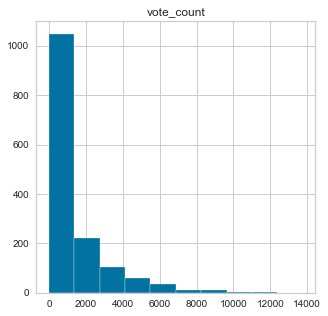

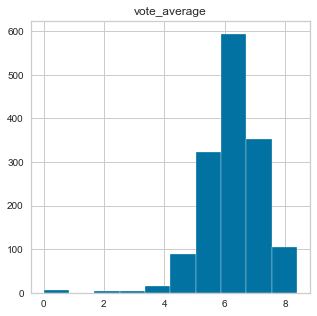

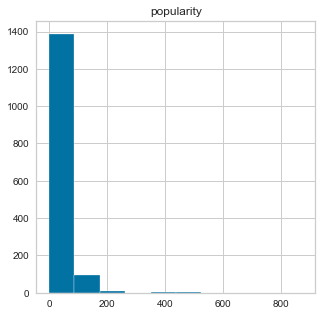

In [12]:
movies_df.hist(column=["vote_count"])
movies_df.hist(column=["vote_average"])
movies_df.hist(column=["popularity"])

In [13]:
movies_df.head(1)

,title,keywords,genres,popularity,vote_count,vote_average,overview,cast,crew
0,Avatar,"[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy, Science Fiction]",150.437577,11800,7.2,"In the 22nd century, a paraplegic Marine is di...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[Stephen E. Rivkin, Rick Carter, Christopher B..."


## Task 1: Find popular movies of particular type
- When a recommender system required to offer recommendations to a new user, it relies on the limited data that the user provided as preferences. In such cases, the system can identify movies based on popularity. For example - suppose the user selected an Action movie as a  preference - the system could list down popular action movies.

##### So based on the data we have. We can consider the following approach :
- We look at the popularity column of our dataset and recommend the top 10 movies to the user.
- We can also consider the average rating of a particular movie in our consideration
- We can also take a weighted average of the above columns .

### Following are list of movies based on popularities

In [14]:
movie_recommendation_by_popularity=movies_df.sort_values('popularity', ascending=[False])
movie_recommendation_by_popularity=movie_recommendation_by_popularity[:10]
movie_recommendation_by_popularity[['title', 'popularity','vote_average','genres']]

,title,popularity,vote_average,genres
314,Minions,875.581305,6.4,"[Family, Animation, Adventure, Comedy]"
76,Interstellar,724.247784,8.1,"[Adventure, Drama, Science Fiction]"
428,Deadpool,514.569956,7.4,"[Action, Adventure, Comedy]"
75,Guardians of the Galaxy,481.098624,7.9,"[Action, Science Fiction, Adventure]"
101,Mad Max: Fury Road,434.278564,7.2,"[Action, Adventure, Science Fiction, Thriller]"
24,Jurassic World,418.708552,6.5,"[Action, Adventure, Science Fiction, Thriller]"
146,Pirates of the Caribbean: The Curse of the Bla...,271.972889,7.5,"[Adventure, Fantasy, Action]"
67,Dawn of the Planet of the Apes,243.791743,7.3,"[Science Fiction, Action, Drama, Thriller]"
147,The Hunger Games: Mockingjay - Part 1,206.227151,6.6,"[Science Fiction, Adventure, Thriller]"
71,Big Hero 6,203.734590,7.8,"[Adventure, Family, Animation, Action, Comedy]"


In [15]:
movie_recommendation_by_vote=movies_df.sort_values('vote_average', ascending=[False])
movie_recommendation_by_vote=movie_recommendation_by_vote[:10]
movie_recommendation_by_vote[['title', 'popularity','vote_average','genres']]

,title,popularity,vote_average,genres
1183,The Godfather,143.659698,8.4,"[Drama, Crime]"
776,Schindler's List,104.469351,8.3,"[Drama, History, War]"
1297,Whiplash,192.528841,8.3,[Drama]
369,Fight Club,146.757391,8.3,[Drama]
915,Spirited Away,118.968562,8.3,"[Fantasy, Adventure, Animation, Family]"
818,The Empire Strikes Back,78.517830,8.2,"[Adventure, Action, Science Fiction]"
783,GoodFellas,63.654244,8.2,"[Drama, Crime]"
54,The Dark Knight,187.322927,8.2,"[Drama, Action, Crime, Thriller]"
1117,American History X,73.567232,8.2,[Drama]
386,The Green Mile,103.698022,8.2,"[Fantasy, Drama, Crime]"


#### Weighted Avarage rating (WR)
 (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:
- R = average for the movie (mean) = (Rating)
- v = number of votes for the movie = (votes)
- m = minimum votes required to be listed in the Top 250 (currently 25000)
- C = the mean vote across the whole report (currently 7.0)

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
r=movies_df['vote_average']
v=movies_df['vote_count']
m=movies_df['vote_count'].quantile(q=.7)
c=movies_df['vote_average'].mean()
movies_df['weighted_average']=(v*r/(v+m))+(m*c/(v+m))

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
result_df=pd.DataFrame(scaler.fit_transform(movies_df[['weighted_average','popularity']]),columns=['weighted_average','popularity'])
movies_df['score']=result_df['weighted_average']*0.5 +result_df['popularity']*0.5

In [18]:
movie_recommendation_by_score=movies_df.sort_values('score', ascending=[False])
movie_recommendation_by_score=movie_recommendation_by_score[:10]
movie_recommendation_by_score[['title', 'popularity','vote_average','genres']]

,title,popularity,vote_average,genres
76,Interstellar,724.247784,8.1,"[Adventure, Drama, Science Fiction]"
75,Guardians of the Galaxy,481.098624,7.9,"[Action, Science Fiction, Adventure]"
314,Minions,875.581305,6.4,"[Family, Animation, Adventure, Comedy]"
428,Deadpool,514.569956,7.4,"[Action, Adventure, Comedy]"
54,The Dark Knight,187.322927,8.2,"[Drama, Action, Crime, Thriller]"
101,Mad Max: Fury Road,434.278564,7.2,"[Action, Adventure, Science Fiction, Thriller]"
369,Fight Club,146.757391,8.3,[Drama]
77,Inception,167.583710,8.1,"[Action, Thriller, Science Fiction, Mystery, A..."
1183,The Godfather,143.659698,8.4,"[Drama, Crime]"
1297,Whiplash,192.528841,8.3,[Drama]


## Task 2: Find similarities among  movies 
- We have to identify movies of similar types to what users watched recently. There could be multiple approaches to do with this.

### How we can find two movies are similar. The following columns could help us with this
- a) Overview: We can compare overviews of different movies to understand whether they are similar. For this, we can  focus on the keywords present in the overview and match them with other columns 
- b) keywords: Same goes with this column too.
- c) genres, Cast, Crew: These three columns can also work as a perfect indicator.

### So, the following steps :
- Merge all these columns and remove all stop words.
- Apply Bag-of-Words techniques. This help to convert the text into numerical feature vectors.
- Next, we can use the cosine distance between two vectors.

In [19]:
movies_df.head(1)

,title,keywords,genres,popularity,vote_count,vote_average,overview,cast,crew,weighted_average,score
0,Avatar,"[culture clash, future, space war, space colon...","[Action, Adventure, Fantasy, Science Fiction]",150.437577,11800,7.2,"In the 22nd century, a paraplegic Marine is di...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[Stephen E. Rivkin, Rick Carter, Christopher B...",7.103391,0.426138


#### First get all tokens from the columns mentioned above

In [20]:
#First get all tokens from overview columns
movies_df['overview'] = movies_df['overview'].apply(lambda x:x.split())
movies_df['tag'] = movies_df['overview'] + movies_df['genres'] + movies_df['keywords'] + movies_df['cast'] + movies_df['crew']
movies_with_tag_df = movies_df.drop(columns=['overview','genres','keywords','cast','crew'])


In [21]:
movies_with_tag_df['tag'] = movies_with_tag_df['tag'].apply(lambda x: " ".join(x))
movies_with_tag_df

,title,popularity,vote_count,vote_average,weighted_average,score,tag
0,Avatar,150.437577,11800,7.2,7.103391,0.426138,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,139.082615,4500,6.9,6.753448,0.360089,"Captain Barbossa, long believed to be dead, ha..."
2,Spectre,107.376788,4466,6.3,6.293688,0.263727,A cryptic message from Bond’s past sends him o...
3,The Dark Knight Rises,112.312950,9106,7.6,7.426141,0.459302,Following the death of District Attorney Harve...
4,John Carter,43.926995,2124,6.1,6.167989,0.206097,"John Carter is a war-weary, former military ca..."
...,...,...,...,...,...,...,...
1489,Clerks,19.748658,755,7.4,6.672936,0.278238,Convenience and video store clerks Dante and R...
1490,Dry Spell,0.048948,1,6.0,6.272961,0.198907,Sasha tries to get her soon-to-be ex husband K...
1491,Tin Can Man,0.332679,1,2.0,6.270050,0.198574,Recently dumped by his girlfirend for another ...
1492,Primer,23.307949,658,6.9,6.476232,0.246789,Friends/fledgling entrepreneurs invent a devic...


#### Apply bag of words
- Here we have to ensure that we remove stop words. It helps to remove the low-level information from our text to focus on the important information.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,stop_words='english')
vector = cv.fit_transform(movies_with_tag_df['tag']).toarray()


####  get similarities among the vectors

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity = cosine_similarity(vector)

### No lets select a data and apply this technique

In [24]:
movies_with_tag_df[movies_with_tag_df['title'] == 'Batman Begins'].index[0]


95

In [25]:
def RecommendMovie(movie,df,similarity):
    index  = df[df['title'] == movie].index [0]
    distance = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    result=[]
    for i in distance[1:10]:
        result.append(df.iloc[i[0]].title)
    return result    

In [26]:
resuls=RecommendMovie('Batman Begins',movies_with_tag_df,cosine_similarity)

In [27]:
result_df=movies_df[movies_df["title"].isin(resuls)].sort_values('score', ascending=[False])
result_df[['title','keywords','genres','popularity','cast','crew','overview','vote_average','score']]

,title,keywords,genres,popularity,cast,crew,overview,vote_average,score
54,The Dark Knight,"[dc comics, crime fighter, secret identity, sc...","[Drama, Action, Crime, Thriller]",187.322927,"[Christian Bale, Heath Ledger, Aaron Eckhart]","[Lucinda Syson, Hans Zimmer, Charles Roven]","[Batman, raises, the, stakes, in, his, war, on...",8.2,0.600187
1183,The Godfather,"[italy, love at first sight, loss of father, p...","[Drama, Crime]",143.659698,"[Marlon Brando, Al Pacino, James Caan]","[Francis Ford Coppola, Francis Ford Coppola, G...","[Spanning, the, years, 1945, to, 1955,, a, chr...",8.4,0.574554
3,The Dark Knight Rises,"[dc comics, crime fighter, terrorist, secret i...","[Action, Crime, Drama, Thriller]",112.312950,"[Christian Bale, Michael Caine, Gary Oldman]","[Hans Zimmer, Charles Roven, Christopher Nolan]","[Following, the, death, of, District, Attorney...",7.6,0.459302
13,Man of Steel,"[saving the world, dc comics, superhero, based...","[Action, Adventure, Fantasy, Science Fiction]",99.398009,"[Henry Cavill, Amy Adams, Michael Shannon]","[Hans Zimmer, Charles Roven, Lloyd Phillips]","[A, young, boy, learns, that, he, has, extraor...",6.5,0.287430
26,Spider-Man 2,"[dual identity, love of one's life, pizza boy,...","[Action, Adventure, Fantasy]",35.149586,"[Tobey Maguire, Kirsten Dunst, James Franco]","[Danny Elfman, Dianne Crittenden, Bill Abbott]","[Peter, Parker, is, going, through, a, major, ...",6.7,0.274119
1336,Boys Don't Cry,"[rape, sex, identity, small town, love, friend...","[Crime, Drama]",15.557144,"[Hilary Swank, Chloë Sevigny, Peter Sarsgaard]","[Suzanne Smith, John Sloss, Kimberly Peirce]","[Female, born,, Teena, Brandon, adopts, his, m...",7.2,0.240060
173,Teenage Mutant Ninja Turtles,"[martial arts, terrorist, hero, mutation, van,...","[Science Fiction, Action, Adventure, Fantasy, ...",143.350376,"[Megan Fox, Will Arnett, William Fichtner]","[Michael Bay, Brian Tyler, Galen Walker]","[The, city, needs, heroes., Darkness, has, set...",5.8,0.227822
9,Batman v Superman: Dawn of Justice,"[dc comics, vigilante, superhero, based on com...","[Action, Adventure, Fantasy]",155.790452,"[Ben Affleck, Henry Cavill, Gal Gadot]","[Hans Zimmer, Charles Roven, Christopher Nolan]","[Fearing, the, actions, of, a, god-like, Super...",5.7,0.206312
425,The Spirit,"[secret identity, robber, mask, frog, based on...","[Action, Comedy, Thriller, Crime, Science Fict...",14.848560,"[Gabriel Macht, Scarlett Johansson, Samuel L. ...","[Frank Miller, Frank Miller, David Newman]","[Down, these, mean, streets, a, man, must, com...",4.7,0.156784


### euclidean Distance

In [28]:
from sklearn.metrics.pairwise import pairwise_kernels
kernels_similarity = pairwise_kernels(vector)

In [29]:
resuls=RecommendMovie('Batman Begins',movies_with_tag_df,kernels_similarity)

In [30]:
result_df=movies_df[movies_df["title"].isin(resuls)].sort_values('score', ascending=[False])
result_df[['title','keywords','genres','popularity','cast','crew','overview','vote_average','score']]

,title,keywords,genres,popularity,cast,crew,overview,vote_average,score
54,The Dark Knight,"[dc comics, crime fighter, secret identity, sc...","[Drama, Action, Crime, Thriller]",187.322927,"[Christian Bale, Heath Ledger, Aaron Eckhart]","[Lucinda Syson, Hans Zimmer, Charles Roven]","[Batman, raises, the, stakes, in, his, war, on...",8.2,0.600187
1183,The Godfather,"[italy, love at first sight, loss of father, p...","[Drama, Crime]",143.659698,"[Marlon Brando, Al Pacino, James Caan]","[Francis Ford Coppola, Francis Ford Coppola, G...","[Spanning, the, years, 1945, to, 1955,, a, chr...",8.4,0.574554
783,GoodFellas,"[prison, based on novel, florida, 1970s, mass ...","[Drama, Crime]",63.654244,"[Robert De Niro, Ray Liotta, Joe Pesci]","[Martin Scorsese, Martin Scorsese, Ellen Lewis]","[The, true, story, of, Henry, Hill,, a, half-I...",8.2,0.463184
3,The Dark Knight Rises,"[dc comics, crime fighter, terrorist, secret i...","[Action, Crime, Drama, Thriller]",112.312950,"[Christian Bale, Michael Caine, Gary Oldman]","[Hans Zimmer, Charles Roven, Christopher Nolan]","[Following, the, death, of, District, Attorney...",7.6,0.459302
561,The Talented Mr. Ripley,"[venice, italy, gay, new york, lovesickness, d...","[Thriller, Crime, Drama]",31.385257,"[Matt Damon, Gwyneth Paltrow, Jude Law]","[Ronna Kress, Walter Murch, Walter Murch]","[Tom, Ripley, is, a, calculating, young, man, ...",7.0,0.261176
517,Blade,"[suicide, hero, vampire, bite, fistfight, supe...","[Horror, Action]",43.815492,"[Wesley Snipes, Stephen Dorff, Kris Kristoffer...","[Harry Cohen, Harry Cohen, Paul Rubell]","[When, Blade's, mother, was, bitten, by, a, va...",6.5,0.246373
173,Teenage Mutant Ninja Turtles,"[martial arts, terrorist, hero, mutation, van,...","[Science Fiction, Action, Adventure, Fantasy, ...",143.350376,"[Megan Fox, Will Arnett, William Fichtner]","[Michael Bay, Brian Tyler, Galen Walker]","[The, city, needs, heroes., Darkness, has, set...",5.8,0.227822
9,Batman v Superman: Dawn of Justice,"[dc comics, vigilante, superhero, based on com...","[Action, Adventure, Fantasy]",155.790452,"[Ben Affleck, Henry Cavill, Gal Gadot]","[Hans Zimmer, Charles Roven, Christopher Nolan]","[Fearing, the, actions, of, a, god-like, Super...",5.7,0.206312
1312,Hobo with a Shotgun,"[female nudity, prostitute, shotgun, pimp, und...","[Action, Comedy, Thriller]",16.900433,"[Rutger Hauer, Gregory Smith, Robb Wells]","[Niv Fichman, Deirdre Bowen, Karim Hussain]","[A, vigilante, homeless, man, pulls, into, a, ...",5.7,0.195570
